In [44]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 1. 팻-테일 현상
* 팻-테일(fat tail) 현상 : 데이터 분포가 가우시안 정규분포와 유사하지만 양 끝(꼬리) 부분이 정규분포보다 두꺼운 현상  
ex)  
금융시장의 블랙 스완(black swan) 현상 : 주식의 수익률은 보통 정규 분포를 따르는 것으로 가정하는데 실제로는 정규분포에서는 자주 발생할 수 없는 극단적인 사건들이 종종 발생하는데 이러한 현상

#### 실제 과거의 주가 데이터 확인해보기

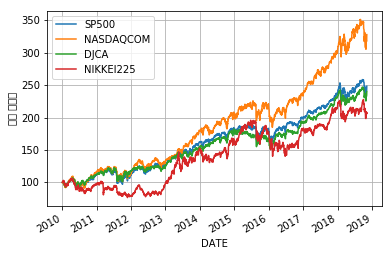

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web

symbols = ['SP500', 'NASDAQCOM', 'DJCA', 'NIKKEI225']
data = pd.DataFrame()

for sym in symbols:
    data[sym] = web.DataReader(sym, data_source='fred')[sym]

data = data.dropna()
(data / data.iloc[0] * 100).plot()
plt.ylabel("주가 수익률")
plt.grid()
plt.show()

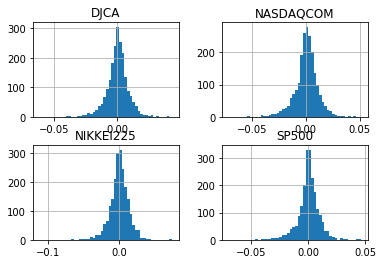

In [41]:
# 수익률 분포의 히스토그램
import numpy as np

log_returns = np.log(data / data.shift(1))
log_returns.hist(bins=50)
plt.show()

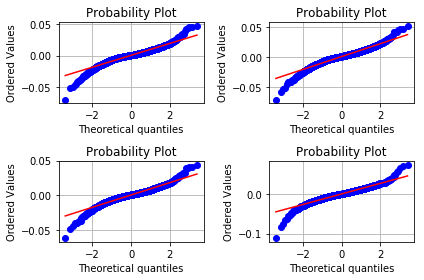

In [42]:
# Q-Q 플롯
import scipy as sp

for i, sym in enumerate(symbols):
    ax = plt.subplot(2, 2, i + 1)
    sp.stats.probplot(log_returns[sym].dropna(), plot=ax)
    plt.grid()
    
plt.tight_layout()
plt.show()

히스토그램을 보면 정규분포와 비슷하지만 Q-Q플롯으로 확인했을 때 정규분포보다 더 극단적인 경우들이 많이 발생하고 있음을 알 수 있다.  
이렇게 팻-테일을 보이는 데이터의 모형에 적합한 것이 **스튜던트 t 분포(student-t distribution)**이다.

# 2. 스튜던트 t 분포
* 확률밀도 함수  
가우시안 정규 분포와 달리 정수값을 가지는 **자유도(degree of freedom)**라는 모수 $ν$를 추가적으로 가진다.
$$ t(x;\mu, \sigma^2, ν) = \frac{Γ(\frac{ν + 1}{2})}{\sqrt{ν\pi}Γ(\frac{ν}{2})}(1 + \frac{(x - \mu)^2}{ν\sigma^2})^{-\frac{ν + 1}{2}} $$
* 감마(Gamma) 함수 $Γ(x)$
    * 특수 함수이다.
    $$ Γ(x) = \int_0^\infty u^{x-1}e^{-u}du $$
    
#### t
스튜던트 t 분포의 확률밀도함수를 그린다.
* 인수
    * `df` : 자유도
    * `loc` : 기댓값
    * `scale` : 표준편차
    
자유도 $ν$가 작으면 가우시안 정규 분포보다 분산이 크고 fat tail을 보이지만,  
자유도가 증가할수록 가우시안 정규 분포로 수렴한다.

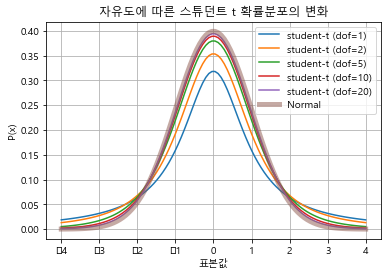

In [45]:
xx = np.linspace(-4, 4, 100)

for df in [1, 2, 5, 10, 20]:
    rv = sp.stats.t(df=df)
    plt.plot(xx, rv.pdf(xx), label=("student-t (dof=%d)" % df))
    
plt.plot(xx, sp.stats.norm().pdf(xx), label="Normal", lw=5, alpha=0.5)
plt.title("자유도에 따른 스튜던트 t 확률분포의 변화")
plt.xlabel("표본값")
plt.ylabel("P(x)")
plt.legend()
plt.grid()
plt.show()

# 3. 모멘트
#### 기댓값
$$ E[X] = \mu $$

#### 분산
$ν > 2$인 경우만 적용됨. $ν = 1, 2$일 때는 분산이 무한대
$$ Var[X] = \frac{ν\sigma^2}{ν - 2} $$

# 4. 통계량 분포
* t 통계량 : 가우시안 정규 분포로부터 얻은 $N$개의 표본 $x_1, \dots, x_N$에서 계산한 표본평균을 표본표준편차로 정규화한 값
* t 통계량은 자유도가 $N - 1$인 스튜던트 t 분포를 이룬다.
$$ t = \frac{\bar x - \mu}{\frac{s}{\sqrt{N}}} ∼ t(x;0,1,N - 1) $$
    * 이 식에서 표본평균 $\bar x$
    $$ \bar x = \frac{x_1 + \dots + x_N}{N} $$
    * 표본표준편차 $s^2$
    $$ s^2 = \frac{1}{N - 1}\sum_{i=1}^N(x_i - \bar x)^2 $$
    이 정리는 추후 정규 분포의 기댓값에 관한 각종 검정(testing)에서 사용된다.

#### 시뮬레이션을 사용하여 표본표준편차로 정규화한 표본평균과 정규분포 비교
* 왼쪽은 $N = 4$, 오른쪽은 $N = 40$

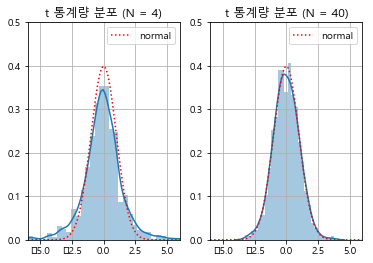

In [46]:
import seaborn as sns

np.random.seed(0)
rv = sp.stats.norm()
M = 1000

plt.subplot(1, 2, 1)
N = 4
x1 = rv.rvs((N, M))
xbar1 = x1.mean(axis=0)
xstd1 = x1.std(axis=0, ddof=1)
x = xbar1 / (xstd1 / np.sqrt(N))
sns.distplot(x, kde=True)
xx = np.linspace(-6, 6, 1000)
plt.plot(xx, rv.pdf(xx), 'r:', label="normal")
plt.xlim(-6, 6)
plt.ylim(0, 0.5)
plt.title("t 통계량 분포 (N = 4)")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
N = 40
x2 = rv.rvs((N, M))
xbar2 = x2.mean(axis=0)
xstd2 = x2.std(axis=0, ddof=1)
x = xbar2 / (xstd2 / np.sqrt(N))
sns.distplot(x, kde=True)
xx = np.linspace(-6, 6, 1000)
plt.plot(xx, rv.pdf(xx), 'r:', label="normal")
plt.xlim(-6, 6)
plt.ylim(0, 0.5)
plt.title("t 통계량 분포 (N = 40)")
plt.grid()
plt.legend()

plt.show()